In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


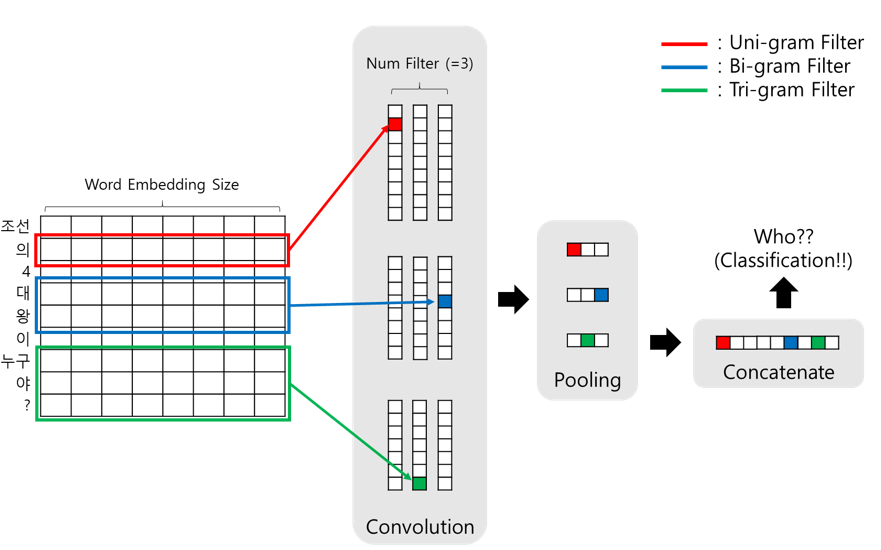

In [2]:
from IPython.display import Image
import os
root_dir = "/gdrive/My Drive/colab/DNN_CNN/week10/TextCNN_Advanced(과제)"
Image(os.path.join(root_dir, "textCNN.PNG"))

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim

import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

class TextCNN(nn.Module):
    def __init__(self, config):
        super(TextCNN, self).__init__()

        # 단어장에 포함된 단어 개수
        self.word_vocab_size = config["word_vocab_size"]

        # 단어 벡터(임베딩) 사이즈
        self.embedding_size = config["embedding_size"]
        
        # 입력 문장의 최대 길이
        self.max_length = config["max_length"]

        # 분류할 태그의 개수
        self.num_labels = config["num_labels"]

        #분류할 pos의 개수\
        self.num_poses = config["num_POS"]

        # CNN Layer의 Activation Function
        self._activation = nn.ReLU()

        # CNN에 각 필터의 개수
        self.num_filters = config["num_filters"]

        # 입력 데이터에 있는 각 형태소 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        # 기존에 사전학습 된 형태소 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        self.embedding = nn.Embedding(num_embeddings=self.word_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)                        #최대 문장 길이가 100이고 실제 길이 10이면 10만 진짜고 나머지는 0으로 padding 처리

        self.pos_embedding = nn.Embedding(num_embeddings=self.num_poses,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)
        
        # nn.Conv1d(in_channel, outchannel, kernel_size)
        #   params:
        #       in_channel : 입력하는 텐서의 embedding 크기
        #       out_channel : 필터 개수
        #       kernel : 필터 크기
        self.convolution_layers = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_size,
                                                           out_channels=self.num_filters,
                                                           kernel_size=int(n_gram)) for n_gram
                                                 in config["filter_size"]])

        self.hidden2num_tag = nn.Linear(in_features=self.num_filters*len(config["filter_size"]), out_features=self.num_labels)

    def forward(self, input, labels=None):
        global word2idx
        # input_feature : [batch, max_length]
        # self.embedding(input_features) : [batch, max_length, embedding_size]
        # lookup_input_features : [batch, embedding_size, max_length] >> CNN에 넣기 위해 permute(0,2,1)로 섞어준 결과 (permutation matrix 같은 느낌임)
        input_features = input[:,:config["max_length"]]
        input_pos= input[:,config["max_length"]:]
        lookup_input_features = self.embedding(input_features).permute(0,2,1)
        lookup_input_pos = self.pos_embedding(input_pos).permute(0,2,1)
        # print(lookup_input_features.shape)
        # print(lookup_input_pos.shape)
        lookup_input_features = torch.cat(tensors=[lookup_input_features,lookup_input_pos],dim=-1)

        # Convolution 한 값을 저장하기위한 리스트
        filter_outputs = []
        for i in range(len(self.convolution_layers)):
            # lookup_input_features : [batch, embedding_size, max_length]
            # self.convolution_layers[bi-gram](lookup_input_features) : [batch, num_filters, max_length-1]
            # ~.permute(0, 2, 1) : [batch, max_length-1, num_filters]
            convolution_output = self.convolution_layers[i](lookup_input_features).permute(0, 2, 1).max(dim=1)[0]  #축1에 대한 max pooling도 같이 진행 
            # convolution_output : [batch, num_filters]

            activated_output = self._activation(convolution_output)
            
            # Convolution 결과 값 저장
            filter_outputs.append(activated_output)

        # filter_outputs : [3, batch, num_filter]
        #               ==> [[batch, num_filters], [batch, num_filters], [batch, num_filters]]
        maxpool_output = torch.cat(tensors=filter_outputs, dim=-1)
        # maxpool_output : [batch, 3*num_filters]
        # 과제 진행 시  torch.cat(tensors=[a, b, c, .....], dim= 차원) concat하고 싶은 텐서를 넣고 몇번째 차원에 대해서 concat 진행할지 써라

        logits = self.hidden2num_tag(maxpool_output)
        # logits : [batch, num_labels]
        

        if labels is not None:  #학습 시
            loss_fnc = nn.CrossEntropyLoss()
            loss = loss_fnc(logits, labels)
            return loss
        else:   #예측 시
            output = torch.argmax(logits, -1)
            return output

In [4]:
from tqdm import tqdm

# 파라미터로 입력받은 파일에 저장된 단어 리스트를 딕셔너리 형태로 저장 (라벨,품사,단어 사전을 Dictionary로)
def load_vocab(f_name):
    vocab_file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')
    print("{} vocab file loading...".format(f_name))

    # default 요소가 저장된 딕셔너리 생성  (PAD: 고정길이 벡터로 맞추기 위한 Padding 값, UNK: VOCA 사전에 없는 단어를 UNK 처리)
    symbol2idx, idx2symbol = {"<PAD>":0, "<UNK>":1}, {0:"<PAD>", 1:"<UNK>"}

    # 시작 인덱스 번호 저장 (위에 1까지 있으니까 2부터 > length = index+1)
    index = len(symbol2idx)
    for line in tqdm(vocab_file.readlines()):
        symbol = line.strip()
        symbol2idx[symbol] = index
        idx2symbol[index]= symbol
        index+=1

    return symbol2idx, idx2symbol

pos2idx, idx2pos = load_vocab("pos_vocab.txt")     ## new ##

# 입력 데이터를 고정 길이의 벡터로 표현하기 위한 함수
def convert_data2feature(data, symbol2idx, max_length=None):
    # data : 자연어로 이루어진 문장 or 질문 유형 라벨
    #     ex) 한글을 창제한 사람이 누구야? // 사람
    # symbol2idx : data에 적합한 symbol2idx 딕셔너리
    # max_length : 고정길이 벡터로 표현하기 위한 최대 길이
    #           ==> 입력 문장에만 해당 , flag라고 생각

    # data가 질문일 경우
    global pos2idx

    if max_length:
        # 고정 길이의 0 벡터 생성
        feature = np.zeros(shape=(max_length), dtype=np.int)
        feature_pos = np.zeros(shape=(max_length), dtype=np.int)    ## new ##
        

        # 입력 문장을 공백 기준으로 split
        words = data.split()

        for idx, word in enumerate(words[:max_length]):
            if word in symbol2idx.keys():
                feature[idx] = symbol2idx[word]
            else:
                feature[idx] = symbol2idx["<UNK>"]
            
            pos= word.split('/')
            if pos[1] in pos2idx.keys():
                feature_pos[idx] = pos2idx[pos[1]]
            else:
                feature_pos[idx] = pos2idx['NA']
        
        # feature = np.concatenate((feature,feature_pos),axis=-1)

        return feature

    # data가 질문 유형 라벨일 경우
    else:
        return symbol2idx[data] #if data in symbol2idx.keys() else symbol2idx["<UNK>"]

# 파라미터로 입력받은 파일로부터 tensor객체 생성
def load_data(config, f_name):
    file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')

    # 단어 딕셔너리 생성
    word2idx, idx2word = load_vocab(config["word_vocab_file"])
    label2idx, idx2label = load_vocab(config["label_vocab_file"])
    
    # return할 문장/라벨 리스트 생성
    indexing_questions, indexing_labels = [], []

    print("{} file loading...".format(f_name))

    # 실제 데이터는 아래와 같은 형태를 가짐
    # 질문 \t 질문 유형
    # 조선/NNP 의/JKG 4/SN 대/NNB 왕/NNG 이/JKS 누구/NP 야/EF ?/SF \t 사람
    for line in tqdm(file.readlines()):
        question, label = line.strip().split('\t')
        indexing_question = convert_data2feature(question, word2idx, config["max_length"])     ## new ##
        indexing_label = convert_data2feature(label, label2idx)
        indexing_questions.append(indexing_question)
        indexing_labels.append(indexing_label)
        
    # 저당된 데이터 객체를 tensor 객체로 변환
    indexing_questions = torch.tensor(indexing_questions, dtype=torch.long)
    indexing_labels = torch.tensor(indexing_labels, dtype=torch.long)

    return indexing_questions,indexing_labels       ## new ##

# tensor 객체를 리스트 형으로 바꾸기 위한 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()

100%|██████████| 42/42 [00:00<00:00, 27611.41it/s]

pos_vocab.txt vocab file loading...


In [5]:
def train(config):
    # 모델 객체 생성
    model = TextCNN(config).cuda()

    # 데이터 Load
    train_input_features, train_labels = load_data(config, config["train_file"])
    test_input_features, test_labels = load_data(config, config["test_file"])

    # 불러온 데이터를 TensorDataset 객체로 변환
    train_features = TensorDataset(train_input_features, train_labels)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])
    
    test_features = TensorDataset(test_input_features, test_labels)
    test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])

    # 모델을 학습하기위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(config["epoch"]):
        losses = []
        for step, batch in enumerate(train_dataloader):
            # .cuda()를 이용하여 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)
            input_features, labels = batch

            # loss 계산
            loss = model(input_features, labels)

            # 변화도 초기화
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            if (step + 1) % 100 == 0:
                print("{} step processed.. current loss : {}".format(step + 1, loss.data.item()))
            losses.append(loss.data.item())

        print("Average Loss : {}".format(np.mean(losses)))
        
        # 모델 저장
        torch.save(model.state_dict(), os.path.join(config["output_dir_path"], "epoch_{}.pt".format(epoch + 1)))

        do_test(model, test_dataloader)


def test(config):
    # 모델 객체 생성
    model = TextCNN(config).cuda()

    # 저장된 가중치 Load
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    # 데이터 Load
    test_input_features, test_labels = load_data(config, config["test_file"])

    # 불러온 데이터 TensorDataset으로 변환
    test_features = TensorDataset(test_input_features, test_labels)
    test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])

    # 평가 함수 호출
    do_test(model, test_dataloader)

def do_test(model, test_dataloader):
    model.eval()
    predicts, answers = [], []
    for step, batch in enumerate(test_dataloader):
        # .cuda() 함수를 이용하요 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)

        # 데이터를 각 변수에 저장
        input_features, labels = batch

        # 예측 라벨 출력
        output = model(input_features)

        # 성능 평가를 위해 예측 값과 정답 값 리스트에 저장
        predicts.extend(tensor2list(output))
        answers.extend(tensor2list(labels))
    # 성능 평가
    print("Accuracy : {}".format(accuracy_score(answers, predicts)))

In [7]:
if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "embedding_output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "train_file":"train.txt",
              "test_file": "test.txt",
              "word_vocab_file":"vocab.txt",
              "label_vocab_file": "label_vocab.txt",
              "POS_vocab_file": "pos_vocab.txt",     ## new ##
              "trained_model_name":"epoch_{}.pt".format(5),
              "output_dir_path":output_dir,
              "word_vocab_size":16385,
              "num_labels": 12,
              "num_POS": 42,                        ## new ##
              "filter_size":[2, 3, 4],
              "num_filters":100,
              "embedding_size":200,
              "max_length": 50,
              "batch_size":32,
              "epoch":5,
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

100%|██████████| 1000/1000 [00:00<00:00, 63418.42it/s]

vocab.txt vocab file loading...
label_vocab.txt vocab file loading...
test.txt file loading...
Accuracy : 0.883


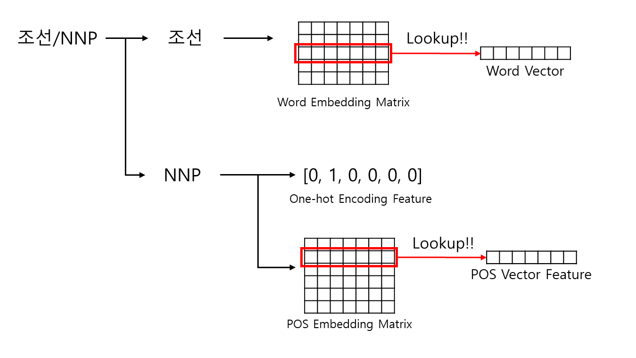

In [ ]:
Image(os.path.join(root_dir, "homework.PNG"))